In [18]:

import math
import os
import pickle
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
from torch.utils.data import DataLoader
from torchvision import datasets
from tqdm import tqdm

from efficient_kan.kan import KAN
from kan_convolutional import KANLinear
from kan_convolutional.KANConv import KAN_Convolutional_Layer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# TRAININGSET + TESTSET DEFINITION

In [88]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
# Train set. Here we sort the MNIST by digits and disable data shuffling
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
sorted_indices = sorted(range(len(train_dataset) // 1), key=lambda idx: train_dataset.targets[idx])
train_subset = torch.utils.data.Subset(train_dataset, sorted_indices)
train_loader = DataLoader(train_subset, batch_size=64, shuffle=False)

# MultiTask training sets
train_loader_tasks = []
indices=[]
for k in range(5):
    indices.append(list(
        filter(lambda idx: train_dataset.targets[idx] in range(k * 2, k * 2 + 2), range(len(train_dataset)))))
    train_loader_tasks.append(
        DataLoader(torch.utils.data.Subset(train_dataset, indices[-1]), batch_size=64, shuffle=True))

# Test set
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_subset = torch.utils.data.Subset(test_dataset, range(len(test_dataset) // 1))
test_loader = DataLoader(test_subset, batch_size=64, shuffle=False)


# ARCHITECTURES DEFINITION

In [54]:
# MLP
class MLP(nn.Module):
    def __init__(self, checkpoint: str | None = None):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 28 * 28)
        self.fc2 = nn.Linear(28 * 28, 256)
        self.fc3 = nn.Linear(256, 10)
        if checkpoint:
            self.load_state_dict(torch.load(checkpoint))
            self.eval()

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [55]:
# KAN
class KAN_small(nn.Module):
    def __init__(self, device=device, checkpoint: str | None = None):
        super(KAN_small, self).__init__()
        self.model = KAN([28 * 28, 128, 10]).to(device)
        if checkpoint:
            self.load_state_dict(torch.load(checkpoint))
            self.eval()

    def forward(self, x):
        return self.model(x)


class KAN_big(nn.Module):
    def __init__(self, device=device):
        super(KAN_big, self).__init__()
        self.model = KAN([28 * 28, 28 * 28, 128, 10]).to(device)

    def forward(self, x):
        return self.model(x)

In [56]:
# KAN_Convolutional_Layer + MLP
class CKAN_BN(nn.Module):
    def __init__(self, device: str = device):
        super().__init__()
        self.conv1 = KAN_Convolutional_Layer(
            n_convs=5,
            kernel_size=(3, 3),
            device=device
        )
        self.bn1 = nn.BatchNorm2d(5)

        self.conv2 = KAN_Convolutional_Layer(
            n_convs=5,
            kernel_size=(3, 3),
            device=device
        )
        self.bn2 = nn.BatchNorm2d(25)

        self.pool1 = nn.MaxPool2d(
            kernel_size=(2, 2)
        )

        self.flat = nn.Flatten()

        self.linear1 = nn.Linear(625, 256)
        self.linear2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.bn2(x)

        x = self.pool1(x)
        x = self.flat(x)
        x = self.linear1(x)
        x = self.linear2(x)
        return x

In [57]:
# KAN_Convolutional_Layer + MLP (without Batch Norm)
class KANC_MLP(nn.Module):
    def __init__(self, device: str = device):
        super().__init__()
        self.conv1 = KAN_Convolutional_Layer(
            n_convs=5,
            kernel_size=(3, 3),
            device=device
        )

        self.conv2 = KAN_Convolutional_Layer(
            n_convs=5,
            kernel_size=(3, 3),
            device=device
        )

        self.pool1 = nn.MaxPool2d(
            kernel_size=(2, 2)
        )

        self.flat = nn.Flatten()

        self.linear1 = nn.Linear(625, 256)
        self.linear2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.conv1(x)

        x = self.pool1(x)

        x = self.conv2(x)
        x = self.pool1(x)
        x = self.flat(x)
        x = self.linear1(x)
        x = self.linear2(x)
        x = F.log_softmax(x, dim=1)
        return x

In [58]:
# Conv2d + KAN
class NormalConvsKAN(nn.Module):
    def __init__(self):
        super(NormalConvsKAN, self).__init__()
        # Convolutional layer, assuming an input with 1 channel (grayscale image)
        # and producing 16 output channels, with a kernel size of 3x3
        self.conv1 = nn.Conv2d(1, 5, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(5, 5, kernel_size=3, padding=1)

        # Max pooling layer
        self.maxpool = nn.MaxPool2d(kernel_size=2)

        # Flatten layer
        self.flatten = nn.Flatten()

        # KAN layer
        self.kan1 = KANLinear(
            245,
            10,
            grid_size=10,
            spline_order=3,
            scale_noise=0.01,
            scale_base=1,
            scale_spline=1,
            base_activation=nn.SiLU,
            grid_eps=0.02,
            grid_range=[0, 1])

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = self.flatten(x)
        x = self.kan1(x)
        x = F.log_softmax(x, dim=1)

        return x

In [59]:
# Conv2d + MLP + (Dropout)
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding='same')
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5, padding='same')

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding='same')
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding='same')

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.25)
        self.dropout3 = nn.Dropout(0.5)

        self.fc1 = nn.Linear(64 * 7 * 7, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        #x = self.dropout1(x)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.maxpool(x)
        #x = self.dropout2(x)

        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        #x = self.dropout3(x)
        x = self.fc2(x)

        #x = F.log_softmax(x, dim=1)
        return x

In [60]:
# KAN_Convolutional_Layer + KAN
class KKAN_Convolutional_Network(nn.Module):
    def __init__(self, device: str = device):
        super().__init__()
        self.conv1 = KAN_Convolutional_Layer(
            n_convs=5,
            kernel_size=(3, 3),
            device=device
        )

        self.conv2 = KAN_Convolutional_Layer(
            n_convs=5,
            kernel_size=(3, 3),
            device=device
        )

        self.pool1 = nn.MaxPool2d(
            kernel_size=(2, 2)
        )

        self.flat = nn.Flatten()

        self.kan1 = KANLinear(
            625,
            10,
            grid_size=10,
            spline_order=3,
            scale_noise=0.01,
            scale_base=1,
            scale_spline=1,
            base_activation=nn.SiLU,
            grid_eps=0.02,
            grid_range=[0, 1],
        )

    def forward(self, x):
        x = self.conv1(x)

        x = self.pool1(x)

        x = self.conv2(x)
        x = self.pool1(x)
        x = self.flat(x)

        x = self.kan1(x)
        x = F.log_softmax(x, dim=1)

        return x

In [61]:
# Conv2d + MLP
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 5, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(5, 5, kernel_size=3, padding=1)

        self.maxpool = nn.MaxPool2d(kernel_size=2)

        self.flatten = nn.Flatten()
        self.fc = nn.Linear(245, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = self.flatten(x)
        x = self.fc(x)
        x = F.log_softmax(x, dim=1)

        return x


class SimpleCNN_2(nn.Module):
    def __init__(self):
        super(SimpleCNN_2, self).__init__()
        self.conv1 = nn.Conv2d(1, 5, kernel_size=3, padding=0)
        self.conv2 = nn.Conv2d(5, 25, kernel_size=3, padding=0)

        self.maxpool = nn.MaxPool2d(kernel_size=2)

        self.flatten = nn.Flatten()
        self.fc = nn.Linear(625, 245)
        self.fc2 = nn.Linear(245, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = self.flatten(x)
        x = self.fc(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)

        return x

# TRAIN() AND TEST() FUNCTIONS

In [52]:
def train(model, checkpoint, optimizer, start_epoch=0, epochs=5, on_epoch_end=None, lr=0, loader=train_loader,
          task_id=None):
    criterion = nn.CrossEntropyLoss()
    # scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.996)
    for epoch in range(start_epoch, epochs + start_epoch):
        model.train()
        losses = []
        accuracies = []
        epoch_start = time.time_ns()
        with tqdm(loader) as pbar:
            for i, (images, labels) in enumerate(pbar):
                if model.__class__.__name__ in ['MLP', 'KAN_small', 'KAN_big']:
                    images = images.view(-1, 28 * 28)
                optimizer.zero_grad()
                output = model(images.to(device))
                loss = criterion(output, labels.to(device))
                loss.backward()
                optimizer.step(closure=lambda: loss)
                accuracy = (output.argmax(dim=1) == labels.to(device)).float().mean()
                pbar.set_postfix(loss=loss.item(), accuracy=accuracy.item(), lr=optimizer.param_groups[0]['lr'])
                losses.append(loss.item())
                accuracies.append(accuracy.item())
                # scheduler.step()
        print(f'Epoch {epoch + 1}, Loss: {loss.item()}')
        epoch_duration = (time.time_ns() - epoch_start) // 1000000
        if on_epoch_end is not None:
            on_epoch_end(model, epoch, losses, accuracies, epoch_duration, lr, task_id)
        # torch.save(model.state_dict(), f'{checkpoint}_ep{epoch + 1}.pth')

In [53]:
def test(model):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    predictions = []
    ground_truths = []
    val_accuracy = 0
    loss = 0
    with torch.no_grad():
        for images, labels in test_loader:
            if model.__class__.__name__ in ['MLP', 'KAN_small', 'KAN_big']:
                images = images.view(-1, 28 * 28)
            output = model(images.to(device))
            loss = criterion(output, labels.to(device))
            predictions.extend(output.argmax(dim=1).to('cpu').numpy())
            ground_truths.extend(labels.to('cpu').numpy())
            val_accuracy += (output.argmax(dim=1) == labels.to(device)).float().mean().item()
    val_accuracy /= len(test_loader)
    print(f"Accuracy: {val_accuracy}")
    return loss.item(), ground_truths, predictions

# INTRA and INTER DATASET TESTS

In [62]:
class EpochStat:
    @staticmethod
    def loadModelStats(name, dir='checkpoint_intra/stats/', subdir='') -> list['EpochStat']:
        return sorted([pickle.load(open(f'{dir}{subdir}{file}', 'rb')) for file in
                       filter(lambda e: name == '_'.join(e.split('_')[:-1]), os.listdir(f'{dir}{subdir}'))],
                      key=lambda e: e.epoch)
        # return [pickle.load(open(f'{dir}{subdir}{file}', 'rb')) for file in
        #         filter(lambda e: name == '_'.join(e.split('_')[:-1]), os.listdir(f'{dir}{subdir}'))]

    def __init__(self, name, epoch, train_loss=0, test_loss=0, labels=None, predictions=None, epoch_duration=0, lr=0,
                 train_losses=None, train_accuracies=None, task_id=None):
        self.name = name
        self.train_loss = train_loss
        self.test_loss = test_loss
        self.epoch = epoch
        self.predictions = predictions
        self.labels = labels
        self.epoch_duration = epoch_duration
        self.lr = lr
        self.train_losses = train_losses
        self.train_accuracies = train_accuracies
        self.task_id = task_id

    def save(self, dir='checkpoint_intra/stats/'):
        os.makedirs(dir, exist_ok=True)
        pickle.dump(self, open(f'{dir}{self.name}_epoch{self.epoch}.pickle', 'wb'))

    def get_accuracy(self):
        accuracy = 0
        for label, prediction in zip(self.labels, self.predictions):
            if label == prediction:
                accuracy += 1
        return accuracy / len(self.labels)


def onEpochEnd(model, epoch, train_losses, train_accuracies, epoch_duration, lr, task_id):
    test_loss, labels, predictions = test(model)
    stat = EpochStat(model.__class__.__name__, epoch, train_losses[-1], test_loss, labels, predictions, epoch_duration,
                     lr, train_losses, train_accuracies, task_id)
    stat.save(
        dir=f'checkpoint_intra/stats/lr_{round(math.log10(lr))}/' if task_id is None else f'checkpoint_inter/stats/lr_{round(math.log10(lr))}/')

## INTRA DATASET TEST

In [89]:
for lr in [1e-3,1e-4, 1e-5, 1e-6, 1e-7][:1]:
    models = [MLP(), KAN_small(),
              CKAN_BN(), KANC_MLP(), NormalConvsKAN(), ConvNet(),
              KKAN_Convolutional_Network(), SimpleCNN()]
    print(f'Using lr={lr}--------------------')
    for model in [x.to(device) for x in models[:2]]:
        print(f'Training model={model.__class__.__name__}')
        # lr = 1e-5 if model.__class__.__name__ in ['MLP', 'KAN_small', 'KAN_big'] else 1e-4
        train(model, f'checkpoint_intra/{model.__class__.__name__}', epochs=30, start_epoch=0,
              optimizer=optim.Adam(model.parameters(), lr=lr), on_epoch_end=onEpochEnd, lr=lr)

Using lr=0.001--------------------
Training model=MLP


100%|██████████| 938/938 [00:17<00:00, 55.02it/s, accuracy=1, loss=0.00261, lr=0.001]  


Epoch 1, Loss: 0.002610342111438513
Accuracy: 0.10071656050955415


100%|██████████| 938/938 [00:17<00:00, 52.40it/s, accuracy=1, loss=0.000695, lr=0.001] 


Epoch 2, Loss: 0.0006952660041861236
Accuracy: 0.10071656050955415


100%|██████████| 938/938 [00:16<00:00, 56.10it/s, accuracy=1, loss=0.000212, lr=0.001]  


Epoch 3, Loss: 0.00021164852660149336
Accuracy: 0.11216162420382166


100%|██████████| 938/938 [00:16<00:00, 55.20it/s, accuracy=1, loss=8.41e-5, lr=0.001]   


Epoch 4, Loss: 8.410733425989747e-05
Accuracy: 0.12430334394904459


100%|██████████| 938/938 [00:16<00:00, 57.75it/s, accuracy=1, loss=3.63e-6, lr=0.001]   


Epoch 5, Loss: 3.6320047911431175e-06
Accuracy: 0.11226114649681529


100%|██████████| 938/938 [00:18<00:00, 51.76it/s, accuracy=1, loss=9.08e-5, lr=0.001]   


Epoch 6, Loss: 9.079699520953e-05
Accuracy: 0.12898089171974522


100%|██████████| 938/938 [00:17<00:00, 52.25it/s, accuracy=1, loss=0.389, lr=0.001]     


Epoch 7, Loss: 0.3889637589454651
Accuracy: 0.1839171974522293


100%|██████████| 938/938 [00:17<00:00, 55.15it/s, accuracy=0.969, loss=0.186, lr=0.001] 


Epoch 8, Loss: 0.18632744252681732
Accuracy: 0.17923964968152867


100%|██████████| 938/938 [00:17<00:00, 53.85it/s, accuracy=1, loss=0.1, lr=0.001]       


Epoch 9, Loss: 0.10034075379371643
Accuracy: 0.12032245222929937


100%|██████████| 938/938 [00:18<00:00, 51.67it/s, accuracy=1, loss=0.0015, lr=0.001]    


Epoch 10, Loss: 0.0015023562591522932
Accuracy: 0.1807324840764331


100%|██████████| 938/938 [00:17<00:00, 55.05it/s, accuracy=1, loss=0.000956, lr=0.001]  


Epoch 11, Loss: 0.000955520779825747
Accuracy: 0.1618232484076433


100%|██████████| 938/938 [00:17<00:00, 53.09it/s, accuracy=1, loss=0.00119, lr=0.001]   


Epoch 12, Loss: 0.0011861653765663505
Accuracy: 0.11982484076433121


100%|██████████| 938/938 [00:17<00:00, 55.02it/s, accuracy=1, loss=0.00107, lr=0.001]   


Epoch 13, Loss: 0.0010689262999221683
Accuracy: 0.15216958598726116


100%|██████████| 938/938 [00:17<00:00, 52.89it/s, accuracy=1, loss=0.00052, lr=0.001]   


Epoch 14, Loss: 0.0005198962171562016
Accuracy: 0.17227308917197454


100%|██████████| 938/938 [00:17<00:00, 54.21it/s, accuracy=1, loss=0.000457, lr=0.001]  


Epoch 15, Loss: 0.00045746544492430985
Accuracy: 0.1532643312101911


100%|██████████| 938/938 [00:17<00:00, 52.41it/s, accuracy=1, loss=0.001, lr=0.001]     


Epoch 16, Loss: 0.0010020860936492682
Accuracy: 0.15475716560509553


100%|██████████| 938/938 [00:18<00:00, 51.36it/s, accuracy=1, loss=0.000298, lr=0.001]  


Epoch 17, Loss: 0.0002977019175887108
Accuracy: 0.1442078025477707


100%|██████████| 938/938 [00:16<00:00, 55.73it/s, accuracy=1, loss=0.00703, lr=0.001]   


Epoch 18, Loss: 0.007030565291643143
Accuracy: 0.10330414012738853


100%|██████████| 938/938 [00:17<00:00, 52.29it/s, accuracy=1, loss=0.00634, lr=0.001]   


Epoch 19, Loss: 0.00633777491748333
Accuracy: 0.12868232484076433


100%|██████████| 938/938 [00:18<00:00, 50.53it/s, accuracy=1, loss=0.0243, lr=0.001]    


Epoch 20, Loss: 0.024297194555401802
Accuracy: 0.1376393312101911


100%|██████████| 938/938 [00:17<00:00, 52.24it/s, accuracy=1, loss=0.0185, lr=0.001]    


Epoch 21, Loss: 0.0184733048081398
Accuracy: 0.1946656050955414


100%|██████████| 938/938 [00:17<00:00, 55.13it/s, accuracy=1, loss=0.00241, lr=0.001]   


Epoch 22, Loss: 0.0024138689041137695
Accuracy: 0.13525079617834396


100%|██████████| 938/938 [00:17<00:00, 52.80it/s, accuracy=1, loss=0.00304, lr=0.001]   


Epoch 23, Loss: 0.003040529787540436
Accuracy: 0.11902866242038217


100%|██████████| 938/938 [00:17<00:00, 53.83it/s, accuracy=1, loss=0.00502, lr=0.001]   


Epoch 24, Loss: 0.0050157043151557446
Accuracy: 0.14629777070063693


100%|██████████| 938/938 [00:17<00:00, 53.32it/s, accuracy=1, loss=0.000107, lr=0.001]  


Epoch 25, Loss: 0.00010710150672821328
Accuracy: 0.11594347133757962


100%|██████████| 938/938 [00:17<00:00, 53.01it/s, accuracy=0.969, loss=0.0424, lr=0.001]


Epoch 26, Loss: 0.04241536557674408
Accuracy: 0.14898487261146498


100%|██████████| 938/938 [00:17<00:00, 52.81it/s, accuracy=1, loss=0.000499, lr=0.001]  


Epoch 27, Loss: 0.000499258516356349
Accuracy: 0.12947850318471338


100%|██████████| 938/938 [00:17<00:00, 52.26it/s, accuracy=1, loss=0.00515, lr=0.001]   


Epoch 28, Loss: 0.005145424511283636
Accuracy: 0.12062101910828026


100%|██████████| 938/938 [00:18<00:00, 50.58it/s, accuracy=1, loss=0.0235, lr=0.001]    


Epoch 29, Loss: 0.023462602868676186
Accuracy: 0.16869028662420382


100%|██████████| 938/938 [00:18<00:00, 50.78it/s, accuracy=0.969, loss=0.0553, lr=0.001]


Epoch 30, Loss: 0.05531330406665802
Accuracy: 0.18531050955414013
Training model=KAN_small


100%|██████████| 938/938 [00:21<00:00, 43.54it/s, accuracy=1, loss=0.00109, lr=0.001]  


Epoch 1, Loss: 0.0010902861831709743
Accuracy: 0.10071656050955415


100%|██████████| 938/938 [00:21<00:00, 43.69it/s, accuracy=1, loss=0.00466, lr=0.001]   


Epoch 2, Loss: 0.004663123283535242
Accuracy: 0.1318670382165605


100%|██████████| 938/938 [00:22<00:00, 42.60it/s, accuracy=1, loss=0.00738, lr=0.001]   


Epoch 3, Loss: 0.007383555173873901
Accuracy: 0.1367436305732484


100%|██████████| 938/938 [00:22<00:00, 42.40it/s, accuracy=1, loss=0.00206, lr=0.001]   


Epoch 4, Loss: 0.0020563125144690275
Accuracy: 0.16062898089171976


100%|██████████| 938/938 [00:22<00:00, 42.19it/s, accuracy=1, loss=0.000191, lr=0.001]  


Epoch 5, Loss: 0.00019067904213443398
Accuracy: 0.10738455414012739


100%|██████████| 938/938 [00:22<00:00, 41.31it/s, accuracy=1, loss=0.00142, lr=0.001]   


Epoch 6, Loss: 0.0014191250083968043
Accuracy: 0.14211783439490447


100%|██████████| 938/938 [00:24<00:00, 38.77it/s, accuracy=1, loss=0.0135, lr=0.001]    


Epoch 7, Loss: 0.013470485806465149
Accuracy: 0.21954617834394904


100%|██████████| 938/938 [00:22<00:00, 40.80it/s, accuracy=1, loss=0.0129, lr=0.001]    


Epoch 8, Loss: 0.012939640320837498
Accuracy: 0.2672173566878981


100%|██████████| 938/938 [00:22<00:00, 42.37it/s, accuracy=0.969, loss=0.0834, lr=0.001]


Epoch 9, Loss: 0.08337582647800446
Accuracy: 0.2398487261146497


100%|██████████| 938/938 [00:21<00:00, 44.29it/s, accuracy=1, loss=0.00106, lr=0.001]   


Epoch 10, Loss: 0.001056293142028153
Accuracy: 0.23775875796178345


100%|██████████| 938/938 [00:20<00:00, 45.10it/s, accuracy=0.969, loss=0.0704, lr=0.001]


Epoch 11, Loss: 0.07044646143913269
Accuracy: 0.2890127388535032


100%|██████████| 938/938 [00:21<00:00, 43.26it/s, accuracy=0.969, loss=0.0341, lr=0.001]


Epoch 12, Loss: 0.03407536447048187
Accuracy: 0.25109474522292996


100%|██████████| 938/938 [00:21<00:00, 42.79it/s, accuracy=1, loss=0.00463, lr=0.001]   


Epoch 13, Loss: 0.004625159315764904
Accuracy: 0.20372213375796178


100%|██████████| 938/938 [00:21<00:00, 43.24it/s, accuracy=1, loss=1.83e-6, lr=0.001]   


Epoch 14, Loss: 1.8327890529690194e-06
Accuracy: 0.1119625796178344


100%|██████████| 938/938 [00:22<00:00, 42.43it/s, accuracy=0.969, loss=0.104, lr=0.001] 


Epoch 15, Loss: 0.10377566516399384
Accuracy: 0.26701831210191085


100%|██████████| 938/938 [00:21<00:00, 42.66it/s, accuracy=0.969, loss=0.116, lr=0.001] 


Epoch 16, Loss: 0.11629791557788849
Accuracy: 0.28682324840764334


100%|██████████| 938/938 [00:21<00:00, 43.66it/s, accuracy=1, loss=2.7e-5, lr=0.001]    


Epoch 17, Loss: 2.6985524527844973e-05
Accuracy: 0.28244426751592355


100%|██████████| 938/938 [00:22<00:00, 42.63it/s, accuracy=0.969, loss=0.0444, lr=0.001]


Epoch 18, Loss: 0.04440885782241821
Accuracy: 0.2806528662420382


100%|██████████| 938/938 [00:21<00:00, 42.92it/s, accuracy=1, loss=0.00122, lr=0.001]   


Epoch 19, Loss: 0.0012204216327518225
Accuracy: 0.29796974522292996


100%|██████████| 938/938 [00:21<00:00, 43.51it/s, accuracy=1, loss=7.05e-5, lr=0.001]   


Epoch 20, Loss: 7.049232954159379e-05
Accuracy: 0.26831210191082805


100%|██████████| 938/938 [00:21<00:00, 43.48it/s, accuracy=1, loss=3.32e-5, lr=0.001]   


Epoch 21, Loss: 3.32491472363472e-05
Accuracy: 0.23775875796178345


100%|██████████| 938/938 [00:21<00:00, 43.82it/s, accuracy=1, loss=3.06e-5, lr=0.001]   


Epoch 22, Loss: 3.062565519940108e-05
Accuracy: 0.21148487261146498


100%|██████████| 938/938 [00:21<00:00, 43.05it/s, accuracy=1, loss=0.00371, lr=0.001]   


Epoch 23, Loss: 0.00371190276928246
Accuracy: 0.27856289808917195


100%|██████████| 938/938 [00:21<00:00, 43.26it/s, accuracy=1, loss=0.00237, lr=0.001]   


Epoch 24, Loss: 0.0023735964205116034
Accuracy: 0.2918988853503185


100%|██████████| 938/938 [00:22<00:00, 41.98it/s, accuracy=1, loss=0.00212, lr=0.001]   


Epoch 25, Loss: 0.002120555844157934
Accuracy: 0.27199442675159236


100%|██████████| 938/938 [00:21<00:00, 42.76it/s, accuracy=1, loss=4.69e-5, lr=0.001]   


Epoch 26, Loss: 4.6874978579580784e-05
Accuracy: 0.25079617834394907


100%|██████████| 938/938 [00:23<00:00, 39.64it/s, accuracy=0.969, loss=0.0587, lr=0.001]


Epoch 27, Loss: 0.05872122570872307
Accuracy: 0.257265127388535


100%|██████████| 938/938 [00:23<00:00, 39.81it/s, accuracy=1, loss=1.68e-7, lr=0.001]   


Epoch 28, Loss: 1.6763786447882012e-07
Accuracy: 0.3030453821656051


100%|██████████| 938/938 [00:22<00:00, 42.36it/s, accuracy=1, loss=0.017, lr=0.001]     


Epoch 29, Loss: 0.017009787261486053
Accuracy: 0.32832404458598724


100%|██████████| 938/938 [00:21<00:00, 43.05it/s, accuracy=1, loss=5.29e-5, lr=0.001]   


Epoch 30, Loss: 5.289530963636935e-05
Accuracy: 0.32255175159235666


## INTER DATASET TEST

In [ ]:
models = [MLP(), KAN_small(),
          CKAN_BN(), KANC_MLP(), NormalConvsKAN(),
          # ConvNet(),
          KKAN_Convolutional_Network(), SimpleCNN()]
for model in [x.to(device) for x in models[:2]]:
    print(f'Training model={model.__class__.__name__}')
    lr = 1e-7 if model.__class__.__name__ in ['MLP', 'KAN_small', 'KAN_big'] else 1e-6
    for i, task in enumerate(train_loader_tasks):
        print(f'Training on task {i}')
        epochs = 12
        train(model, f'checkpoint_inter/{model.__class__.__name__}', epochs=epochs, start_epoch=i * epochs,
              optimizer=optim.Adam(model.parameters(), lr=lr), on_epoch_end=onEpochEnd, lr=lr, loader=task, task_id=i)

# RESULTS PLOTTING

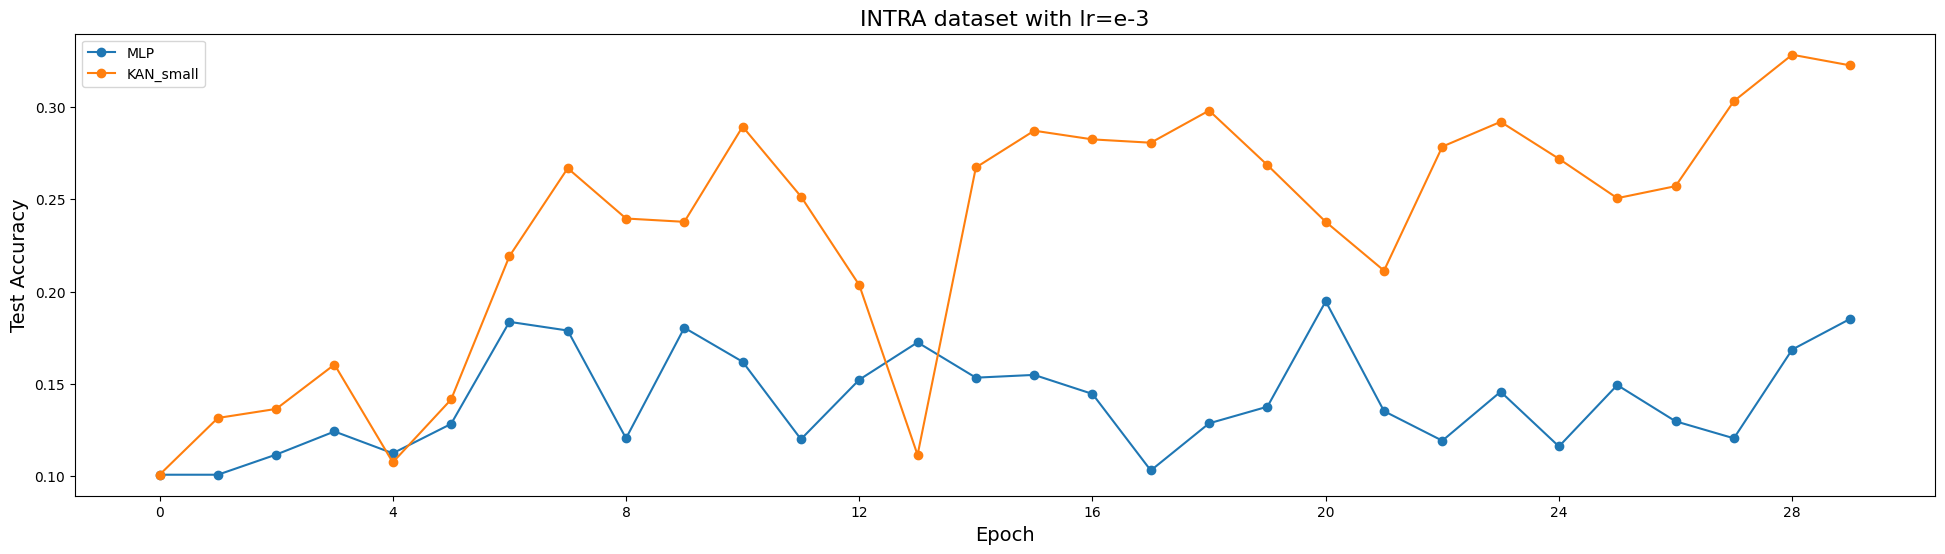

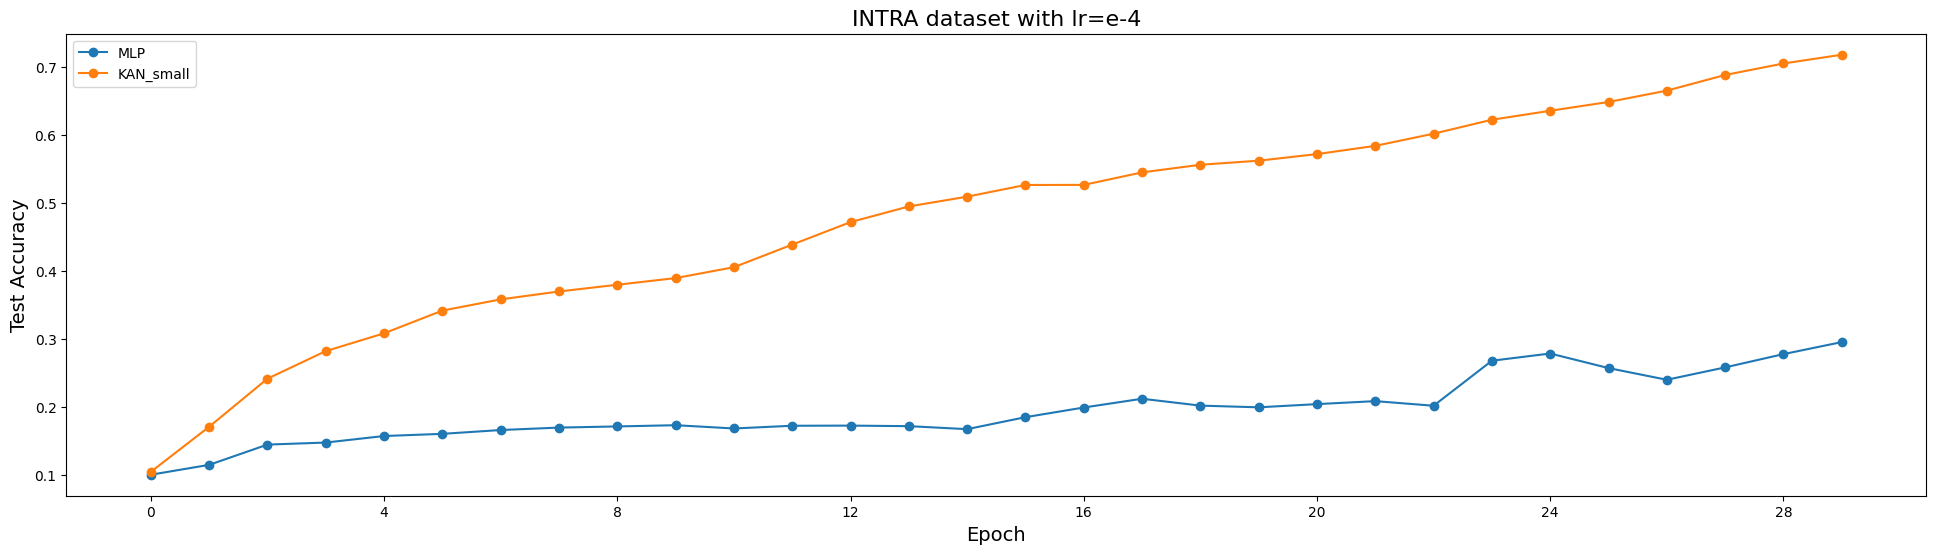

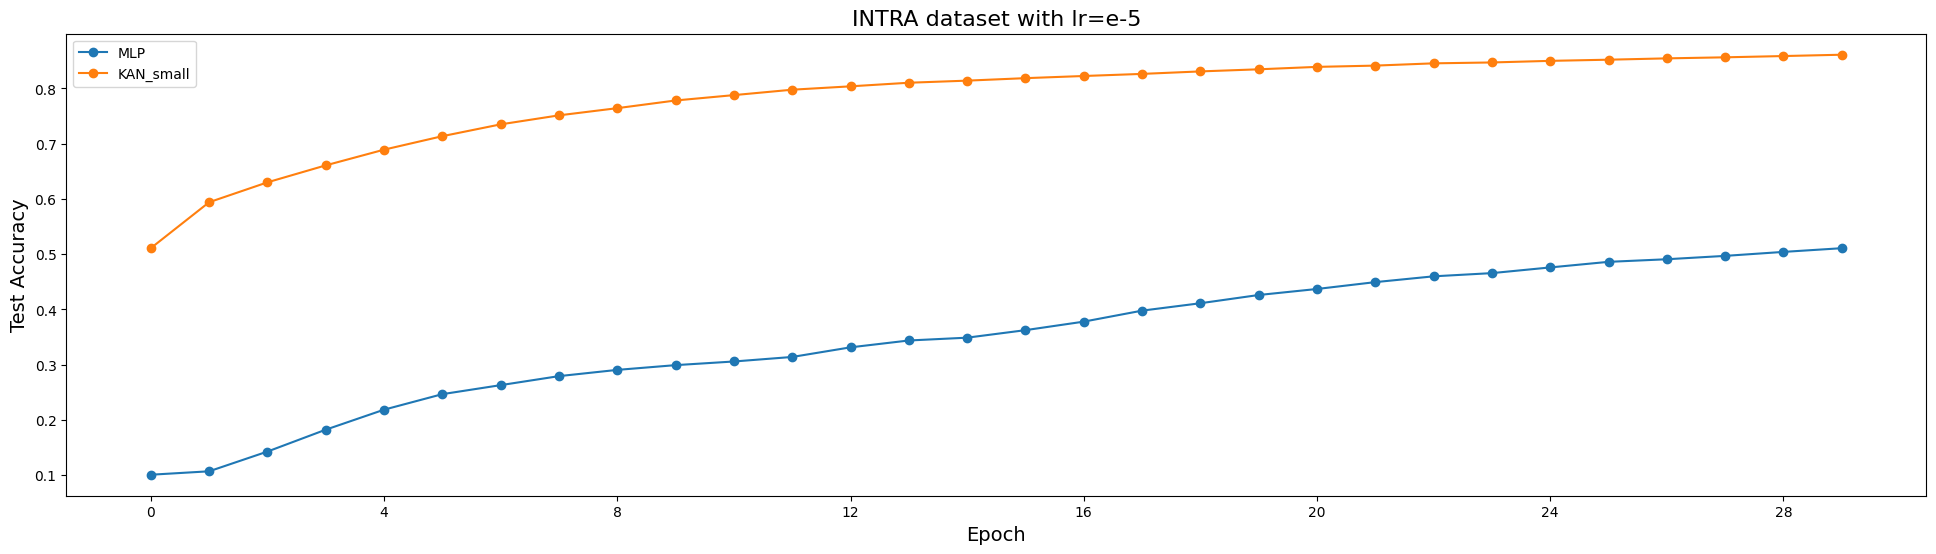

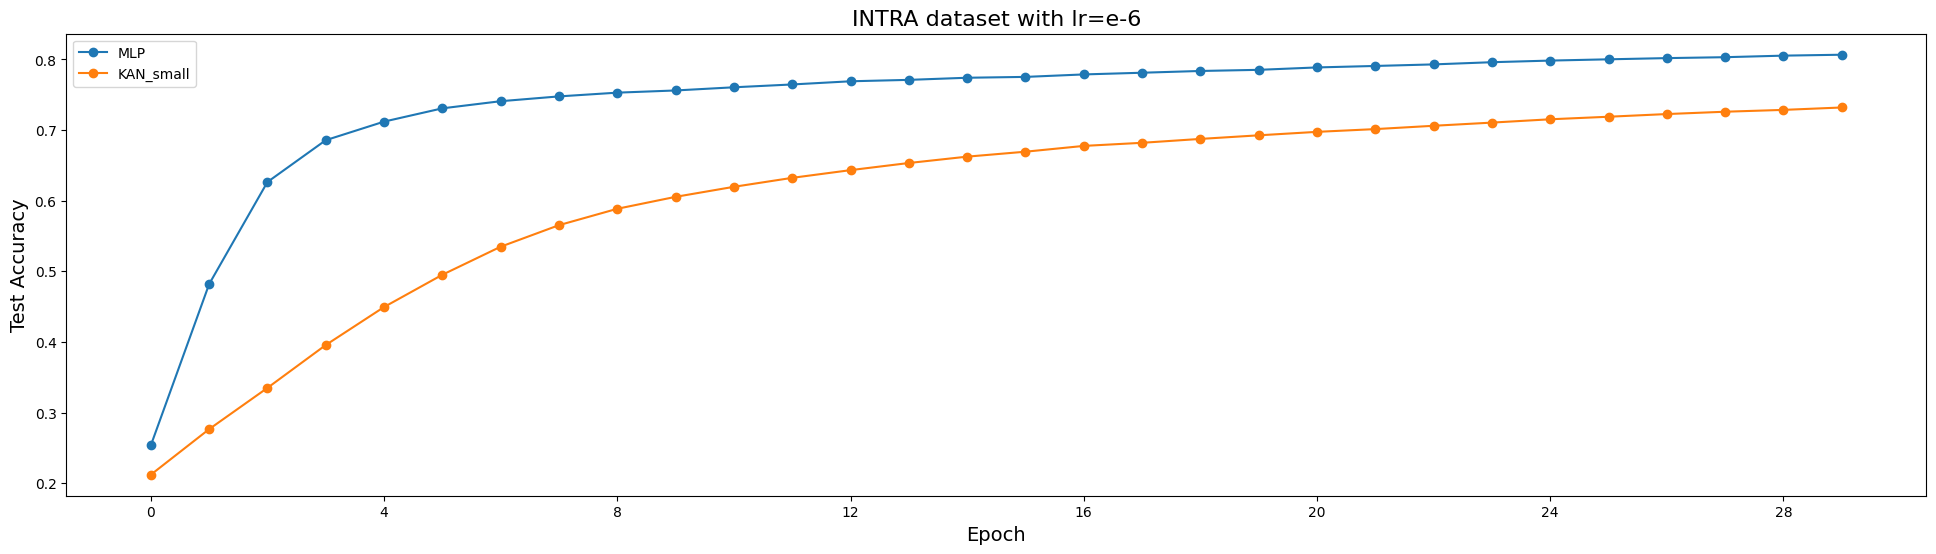

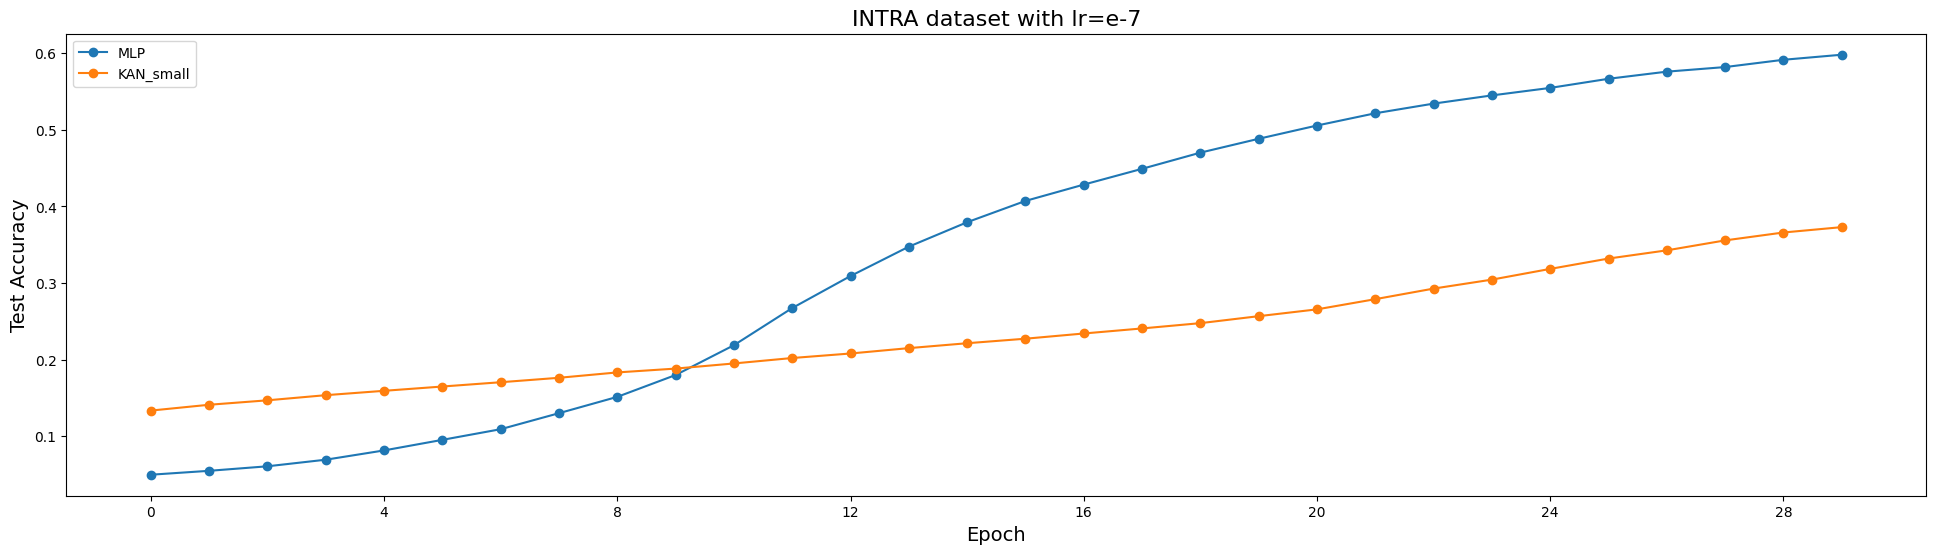

In [95]:
models = [MLP(), KAN_small(),
          CKAN_BN(), KANC_MLP(), NormalConvsKAN(), ConvNet(),
          KKAN_Convolutional_Network(), SimpleCNN()]
for lr in [1e-3, 1e-4, 1e-5, 1e-6, 1e-7]:
    fig, ax = plt.subplots()
    batches = [
        0,
        5923,
        6742,
        5958,
        6131,
        5842,
        5421,
        5918,
        6265,
        5851,
        # 5949,
    ]
    granularity = 1
    for name in list(map(lambda e: e.__class__.__name__, models[:2])):
        stats = EpochStat.loadModelStats(name, dir='checkpoint_intra/stats/', subdir=f'lr_{round(math.log10(lr))}/')
        ax.plot(list(map(lambda e: e.get_accuracy(), stats)), label=name, marker='o')
        # ax.plot(list(map(lambda e: e.train_accuracies, stats))[0][::granularity], label=name)
    plt.legend()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    # ax.set_xticks([x // 64 // granularity for x in itertools.accumulate(batches)])
    # ax.set_xticklabels(range(10))
    # plt.vlines(x=[x // 64 // granularity for x in itertools.accumulate(batches)], ymin=0, ymax=1, colors='black',
    #            alpha=0.65, linestyles='dashed')
    # plt.xlabel('Train Digits Batches', fontdict={'fontsize': 14})
    # plt.ylabel('Train batch Loss', fontdict={'fontsize': 14})
    # plt.title('Train batch loss spikes show up when a new digit is submitted', fontdict={'fontsize': 16})
    plt.xlabel('Epoch', fontdict={'fontsize': 14})
    plt.ylabel('Test Accuracy', fontdict={'fontsize': 14})
    plt.title(f'INTRA dataset with lr=e{round(math.log10(lr))}', fontdict={'fontsize': 16})
    # plt.vlines(x=range(0, 30,6)[1:], ymin=0, ymax=0.5, colors='black',alpha=0.65, linestyles='dashed')
    fig.set_size_inches(24, 6)
    plt.show()

## CONFUSION MATRICES PLOTTING

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

models = [MLP(), KAN_small(),
          CKAN_BN(), KANC_MLP(), NormalConvsKAN(), ConvNet(),
          KKAN_Convolutional_Network(), SimpleCNN()]
plt.rc('font', size=18)
for name in list(map(lambda e: e.__class__.__name__, models[:2])):
    stats = EpochStat.loadModelStats(name, dir='checkpoint_inter/stats/', subdir='')
    for stat in stats[:]:
        cm = confusion_matrix(stat.labels, stat.predictions, labels=range(10))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
        disp.plot()
        fig = disp.ax_.get_figure()
        fig.set_figwidth(8)
        fig.set_figheight(8)
        plt.figtext(0.445, 0.85, f'{name.replace("KAN_small", "KAN")} Epoch: {stat.epoch}', ha='center', fontsize=22)
        fig.savefig(f'png/inter/lr_-6/{name} ep{stat.epoch}.png')